In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import unidecode
import nltk

from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud

In [3]:
#read dataset
train_set = pd.read_csv("../input/sentiment-analysis-on-movie-reviews/train.tsv.zip",sep = '\t')
test_set= pd.read_csv("../input/sentiment-analysis-on-movie-reviews/test.tsv.zip",sep = '\t')

train_set.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
print(len(train_set))
print(len(test_set))

156060
66292


In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [6]:
train_set.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [7]:
train_set.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [8]:
target_category = train_set['Sentiment'].unique()
target_category=list(map(str,target_category))
print(target_category)

['1', '2', '3', '4', '0']


In [9]:
train_set = train_set[['Phrase','Sentiment']]
train_set.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


<AxesSubplot:xlabel='Sentiment'>

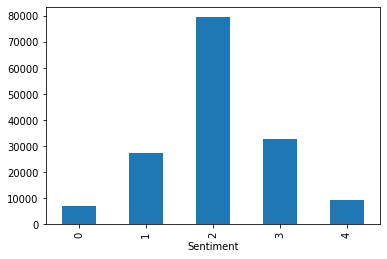

In [10]:
train_set.groupby("Sentiment").Sentiment.count().plot.bar(ylim=0)

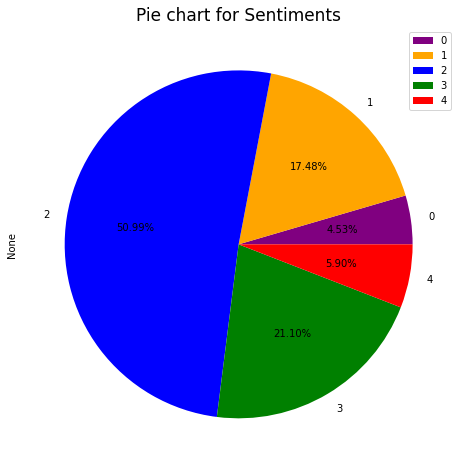

In [11]:
category = train_set.groupby('Sentiment').size()

category.plot(kind='pie', subplots=True, figsize=(10, 8), autopct = "%.2f%%", colors=['purple','orange','blue','green','red'])
plt.title("Pie chart for Sentiments",fontsize=17)
plt.legend()
plt.show()

In [12]:
phrase = train_set['Phrase']
phrase.head(10)

0    A series of escapades demonstrating the adage ...
1    A series of escapades demonstrating the adage ...
2                                             A series
3                                                    A
4                                               series
5    of escapades demonstrating the adage that what...
6                                                   of
7    escapades demonstrating the adage that what is...
8                                            escapades
9    demonstrating the adage that what is good for ...
Name: Phrase, dtype: object

In [13]:
sentiment = train_set["Sentiment"]
sentiment.head(10)

0    1
1    2
2    2
3    2
4    2
5    2
6    2
7    2
8    2
9    2
Name: Sentiment, dtype: int64

In [14]:
def preprocessDataset(text): 
        
    text = str(text)
    
    #remove single quotes 
    text = text.replace("'", "")
    
    
    #word tokenization using text-to-word-sequence
    tokenized_train_set = text_to_word_sequence(text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=" ")


    #stop word removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
    #print (stop_words)
     
    #join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
    #print(stopwordremove_text)
        
    #remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
    #print(output)
        
    #Stemming
    stemmer= PorterStemmer()

    stem_input=nltk.word_tokenize(numberremove_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])
    #print(stem_text)
    
    #lemmatization
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = nltk.word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
    #print(lem_text)
    

    return lem_text

In [15]:
train_set['Phrase'] = train_set['Phrase'].apply(preprocessDataset)
phrase = train_set['Phrase']
sentiment = train_set['Sentiment']
phrase.head()

0    seri escapad demonstr adag good goo also good ...
1                  seri escapad demonstr adag good goo
2                                                 seri
3                                                     
4                                                 seri
Name: Phrase, dtype: object

In [16]:
def wordCollection(phrase, sentiment):
    words = []
    for i in phrase[phrase['Sentiment'] == sentiment]['Phrase'].str.split():
        for j in i:
            words.append(j)
    return words

In [17]:
negative = wordCollection(train_set,0)
somewhat_negative = wordCollection(train_set,1)
neutral = wordCollection(train_set,2)
somewhat_positive = wordCollection(train_set,3)
positive = wordCollection(train_set,4)

**Most used words under negative lable**

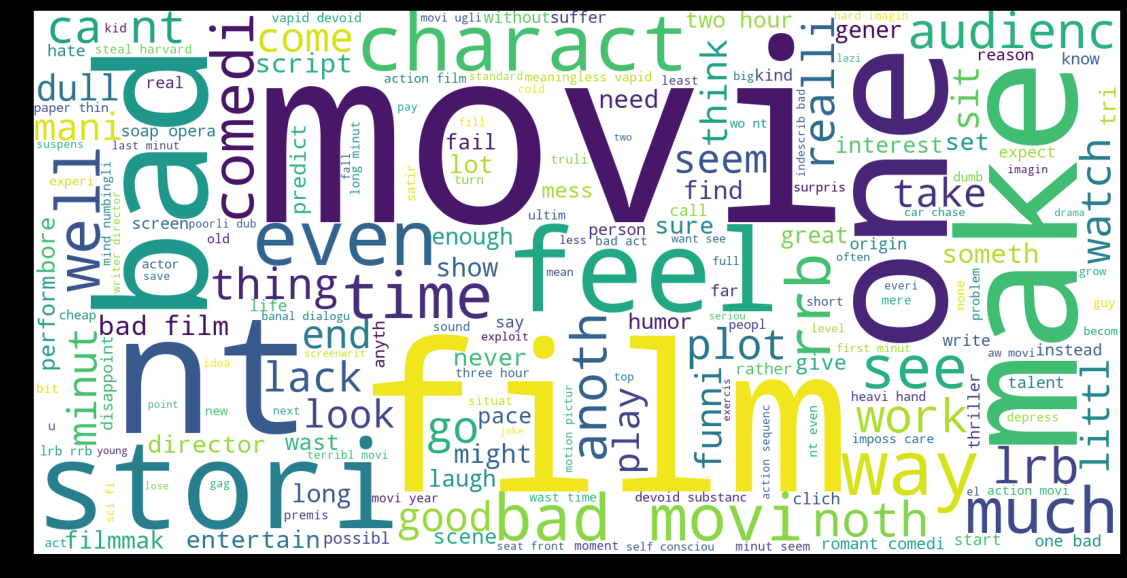

In [18]:
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(negative))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)

**Most used words under somewhat negative lable**

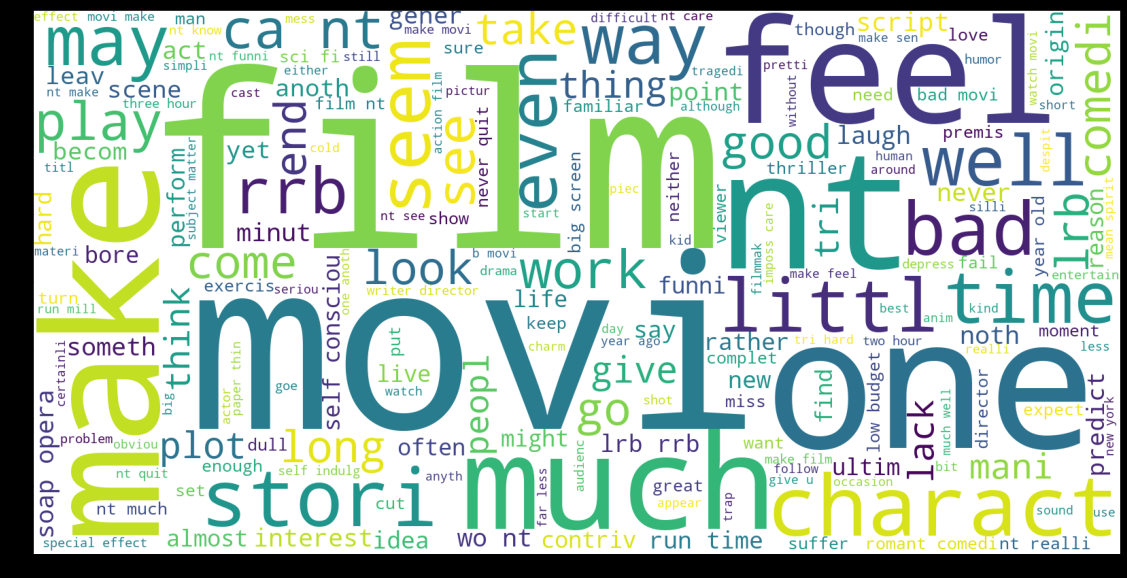

In [19]:
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(somewhat_negative))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)

**Most used words under neutral lable**

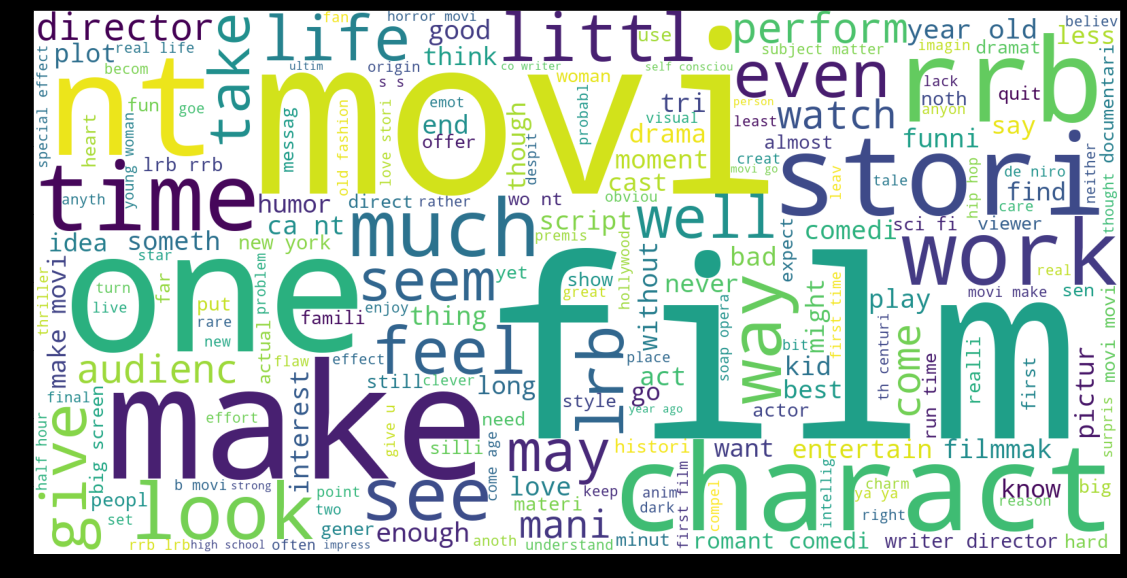

In [20]:
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(neutral))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)

**Most used words under somewhat postive lable**

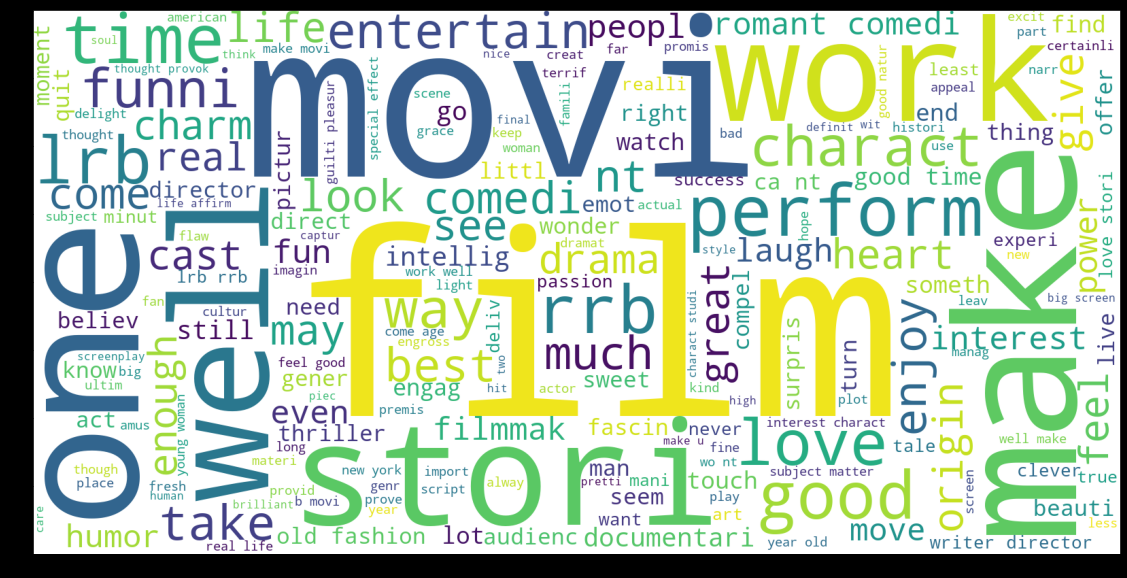

In [21]:
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(somewhat_positive))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)

**Most used words under positive lable**

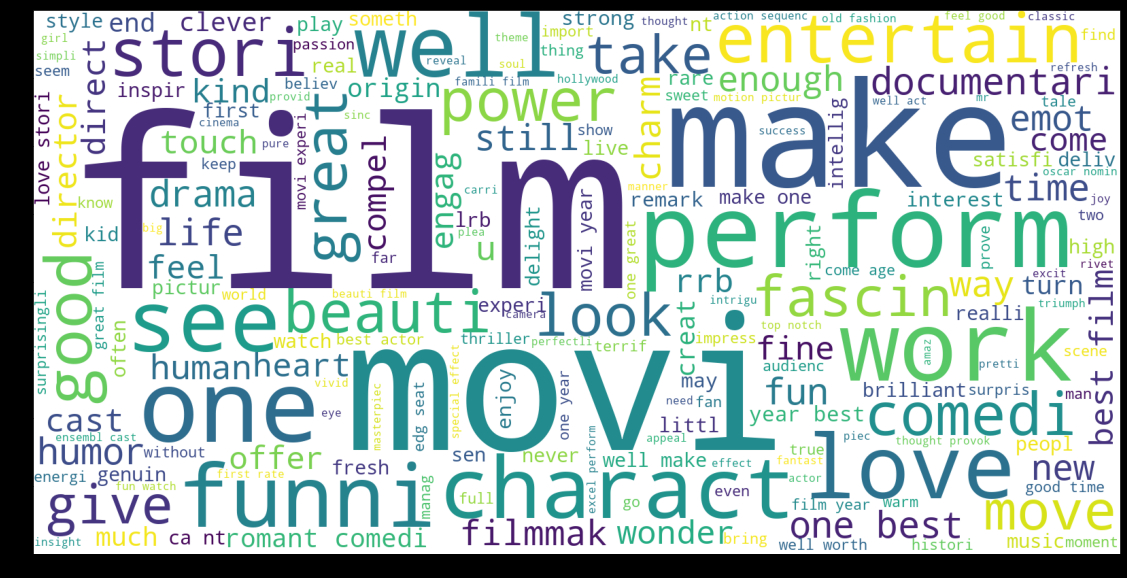

In [22]:
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(positive))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)

In [23]:
list_data = list(zip(phrase, sentiment))
   
train_set = pd.DataFrame(list_data,columns = ['Phrase', 'Sentiment'])
train_set.head(20)

,Phrase,Sentiment
0,seri escapad demonstr adag good goo also good ...,1
1,seri escapad demonstr adag good goo,2
2,seri,2
3,,2
4,seri,2
5,escapad demonstr adag good goo,2
6,,2
7,escapad demonstr adag good goo,2
8,escapad,2
9,demonstr adag good goo,2


after removing stop words some rows of the phrase colums has missing data. So we have to remove those rows 

In [24]:
#remove empty rows 
train_set['Phrase'].replace('', np.nan, inplace=True)
train_set.dropna(subset = ["Phrase"], inplace=True)
train_set.head(20)

,Phrase,Sentiment
0,seri escapad demonstr adag good goo also good ...,1
1,seri escapad demonstr adag good goo,2
2,seri,2
4,seri,2
5,escapad demonstr adag good goo,2
7,escapad demonstr adag good goo,2
8,escapad,2
9,demonstr adag good goo,2
10,demonstr adag,2
11,demonstr,2


In [25]:
#after removing empty rows
print(len(train_set))

154674


In [26]:
phrase = train_set['Phrase']
sentiment = train_set['Sentiment']

phrase.head()

0    seri escapad demonstr adag good goo also good ...
1                  seri escapad demonstr adag good goo
2                                                 seri
4                                                 seri
5                       escapad demonstr adag good goo
Name: Phrase, dtype: object

**Split dataset for train/test**

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(phrase,sentiment, test_size = 0.3, random_state = 60,shuffle=True, stratify=sentiment)

print(len(X_train))
print(len(X_test))

108271
46403


**Naive Bayes Classifier**

In [28]:
vectorizer = TfidfVectorizer()
tfidf_text = vectorizer.fit_transform(X_train)
#print(tfidf_text)


#--Training the classifier with  Naive Bayes--

nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train,Y_train)

test_predict = nb.predict(X_test)

train_accuracy = round(nb.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))


Naive Bayes Train Accuracy Score : 61% 
Naive Bayes Test Accuracy Score  : 58% 

              precision    recall  f1-score   support

           1       0.04      0.55      0.07       136
           2       0.24      0.51      0.33      3891
           3       0.90      0.60      0.72     35440
           4       0.36      0.52      0.42      6749
           0       0.04      0.59      0.07       187

    accuracy                           0.58     46403
   macro avg       0.31      0.55      0.32     46403
weighted avg       0.76      0.58      0.64     46403



In [29]:
sgd = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier()),
               ])

sgd.fit(X_train, Y_train)

test_predict = sgd.predict(X_test)

train_accuracy = round(sgd.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("SVM Train Accuracy Score : {}% ".format(train_accuracy ))
print("SVM Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

SVM Train Accuracy Score : 57% 
SVM Test Accuracy Score  : 56% 

              precision    recall  f1-score   support

           1       0.07      0.51      0.12       276
           2       0.11      0.49      0.18      1871
           3       0.95      0.57      0.71     39283
           4       0.23      0.51      0.31      4363
           0       0.12      0.55      0.20       610

    accuracy                           0.56     46403
   macro avg       0.30      0.53      0.30     46403
weighted avg       0.83      0.56      0.64     46403



In [30]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),
               ])

dt.fit(X_train, Y_train)

test_predict = dt.predict(X_test)

train_accuracy = round(dt.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

Decision Tree Train Accuracy Score : 87% 
Decision Tree Test Accuracy Score  : 61% 

              precision    recall  f1-score   support

           1       0.42      0.39      0.40      2241
           2       0.50      0.49      0.49      8229
           3       0.75      0.72      0.74     24672
           4       0.49      0.53      0.51      9223
           0       0.35      0.48      0.41      2038

    accuracy                           0.61     46403
   macro avg       0.50      0.52      0.51     46403
weighted avg       0.62      0.61      0.62     46403



In [31]:
knn = Pipeline([('tfidf', TfidfVectorizer()),
                ('knn', KNeighborsClassifier(n_neighbors=5, metric='euclidean')),
               ])

knn.fit(X_train, Y_train)

test_predict = knn.predict(X_test)

train_accuracy = round(knn.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("K-Nearest Neighbour Train Accuracy Score : {}% ".format(train_accuracy ))
print("K-Nearest Neighbour Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))


K-Nearest Neighbour Train Accuracy Score : 72% 
K-Nearest Neighbour Test Accuracy Score  : 61% 

              precision    recall  f1-score   support

           1       0.35      0.40      0.38      1865
           2       0.46      0.49      0.47      7608
           3       0.80      0.67      0.73     28032
           4       0.42      0.54      0.47      7615
           0       0.26      0.57      0.36      1283

    accuracy                           0.61     46403
   macro avg       0.46      0.53      0.48     46403
weighted avg       0.65      0.61      0.62     46403



In [32]:
test_set.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


**Train the test set with the Decison Tree model**

In [33]:
test_set['Phrase'] = test_set['Phrase'].apply(preprocessDataset)

test_id = test_set['PhraseId']
test_text = test_set['Phrase']
y_prdict = dt.predict(test_text)

In [34]:
submission = pd.DataFrame(list(zip(test_id, y_prdict)),
               columns =['PhraseId', 'Sentiment'])
submission.head(20)

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
5,156066,2
6,156067,2
7,156068,2
8,156069,2
9,156070,2


In [35]:
submission.to_csv('submission.csv', index=False)